In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

numpy     1.16.3
altair    3.0.1
xarray    0.12.0
pandas    0.24.2



# 0. Utility functions

In [4]:
from utils.load import load_ko_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors, branch_stat)

# 1. Load the simulation data

In [5]:
ko_df, debug_info = load_ko_data()

In [6]:
ko_df.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.059225,ACALD,ACALD,Khodayari,fbaA,-0.059127
1,-0.004108,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,fbaA,-0.004101
2,0.000028,ACKr,ACKr,Khodayari,fbaA,0.000028
3,94.519769,ACONTa,ACONTa,Khodayari,fbaA,94.364274
4,94.276304,ACONTb,ACONTb,Khodayari,fbaA,94.121209


### Preprocess data

In [7]:
xdf = process_data(ko_df, author="Ishii")

In [62]:
xdf.sel(dict(author=["Khodayari","Ishii"], sample_id = "gnd")).to_dataframe()

sample_id          flux  normalized_flux  relative_error  \
BiGG_ID  author                                                               
AKGDH    Khodayari       gnd  6.956404e+00        71.978004       15.319995   
         Ishii           gnd  2.482000e+00        85.000000        0.000000   
CS       Khodayari       gnd  9.275172e+00        95.970333       11.138580   
         Ishii           gnd  3.153600e+00       108.000000        0.000000   
EDA      Khodayari       gnd  1.116817e-09         0.000000        0.000000   
         Ishii           gnd  0.000000e+00         0.000000        0.000000   
FBA      Khodayari       gnd  5.122295e+00        53.000460       43.010258   
         Ishii           gnd  2.715600e+00        93.000000        0.000000   
FUM      Khodayari       gnd  1.274234e+01       131.845144       30.539747   
         Ishii           gnd  2.949200e+00       101.000000        0.000000   
G6PDH2r  Khodayari       gnd  4.395872e+00        45.484146      100.000000   
         Ishii           gnd  0.000000e+00         0.000000        0.000000   
GAPD     Khodayari       gnd  1.048111e+01       108.448145       40.413107   
         Ishii           gnd  5.314400e+00       182.000000        0.000000   
GLCptspp Khodayari       gnd  9.454786e+00        97.828804        2.171196   
         Ishii           gnd  2.920000e+00       100.000000        0.000000   
GND      Khodayari       gnd  6.549248e-07         0.000000        0.000000   
         Ishii           gnd  0.000000e+00         0.000000        0.000000   
ICDHyr   Khodayari       gnd  8.540603e+00        88.369741        4.978773   
         Ishii           gnd  2.715600e+00        93.000000        0.000000   
ICL      Khodayari       gnd  9.166613e-01         9.484707       40.720582   
         Ishii           gnd  4.672000e-01        16.000000        0.000000   
MALS     Khodayari       gnd  8.855211e-01         9.162499       42.734384   
         Ishii           gnd  4.672000e-01        16.000000        0.000000   
MDH      Khodayari       gnd  1.331491e+01       137.769507       17.751715   
         Ishii           gnd  3.416400e+00       117.000000        0.000000   
PDH      Khodayari       gnd  1.043821e+01       108.004257       27.513922   
         Ishii           gnd  4.350800e+00       149.000000        0.000000   
PGI      Khodayari       gnd  5.107272e+00        52.845015       46.621197   
         Ishii           gnd  2.890800e+00        99.000000        0.000000   
PGM      Khodayari       gnd  8.475444e+00        87.695539       49.308937   
         Ishii           gnd  5.051600e+00       173.000000        0.000000   
PPC      Khodayari       gnd -5.048449e-01        -5.223637      274.121248   
         Ishii           gnd  8.760000e-02         3.000000        0.000000   
PTAr     Khodayari       gnd -1.873428e-02        -0.193844      100.000000   
         Ishii           gnd  0.000000e+00         0.000000        0.000000   
PYK      Khodayari       gnd  5.046669e-01         5.221796       92.206275   
         Ishii           gnd  1.956400e+00        67.000000        0.000000   
RPE      Khodayari       gnd -9.288653e-05         0.000000      100.000000   
         Ishii           gnd  1.460000e-01         5.000000        0.000000   
RPI      Khodayari       gnd  9.089316e-05         0.000000      100.000000   
         Ishii           gnd  1.460000e-01         5.000000        0.000000   
SUCDi    Khodayari       gnd  1.253894e+01       129.740611       28.456051   
         Ishii           gnd  2.949200e+00       101.000000        0.000000   
TALA     Khodayari       gnd -3.132023e-04         0.000000      100.000000   
         Ishii           gnd  2.920000e-02         1.000000        0.000000   
TKT1     Khodayari       gnd -5.735963e-05         0.000000      100.000000   
         Ishii           gnd  2.920000e-02         1.000000        0.000000   
TPI      Khodayari       gnd  5.128585e+00        53.065544       42.

In [8]:
branch_stat = branch_stat(xdf)

No data for branch point MDH_ME


In [9]:
xdf.BiGG_ID

<xarray.DataArray 'BiGG_ID' (BiGG_ID: 25)>
array(['AKGDH', 'CS', 'EDA', 'FBA', 'FUM', 'G6PDH2r', 'GAPD', 'GLCptspp',
       'GND', 'ICDHyr', 'ICL', 'MALS', 'MDH', 'PDH', 'PGI', 'PGM', 'PPC',
       'PTAr', 'PYK', 'RPE', 'RPI', 'SUCDi', 'TALA', 'TKT1', 'TPI'],
      dtype=object)
Coordinates:
  * BiGG_ID  (BiGG_ID) object 'AKGDH' 'CS' 'EDA' 'FBA' ... 'TALA' 'TKT1' 'TPI'

# 2. Calculate error metrics

In [10]:
x_rel_error = relative_errors(xdf, author="Ishii")

In [11]:
x_norm_error = summary_errors(xdf, author="Ishii")

# 3. Visualize

### Summary normalized error for the models

In [12]:
from utils.vis import heatmap, summary_chart, jitter_summary_chart

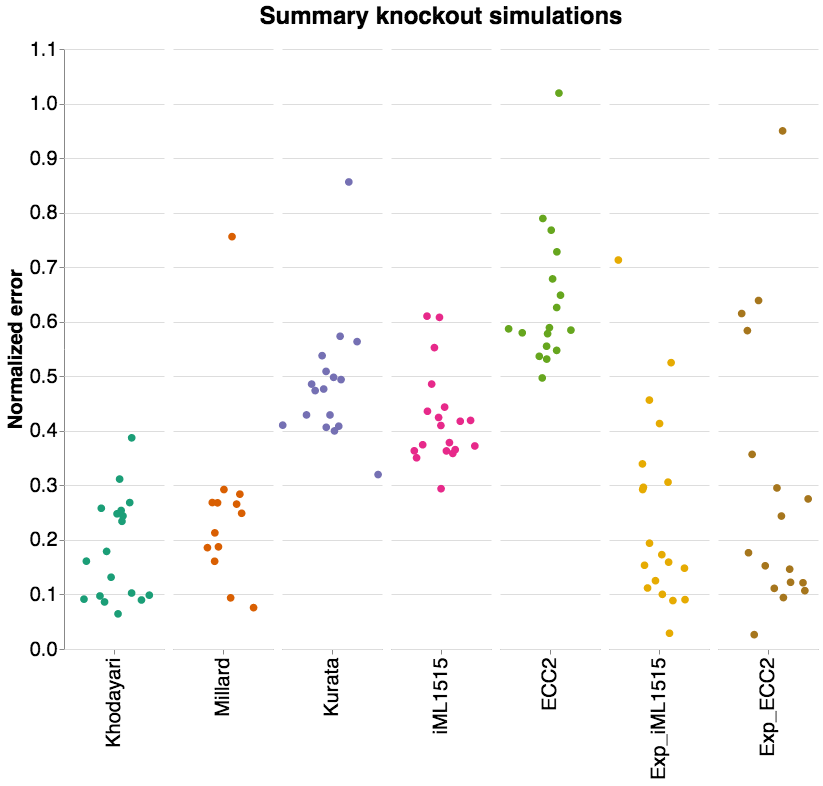

In [13]:
jitter_summary_chart(norm_error=x_norm_error,
              author="Ishii",
              title="Summary knockout simulations",
              sort_list=["Khodayari", "Millard", "Kurata", "iML1515", "ECC2", "Exp_iML1515", "Exp_ECC2"],
              opacity = False,
              color_scheme = "dark2")

In [14]:
#summary_chart(norm_error=x_norm_error,
#              author="Ishii",
#              title="Normalized error knockout simulations",
#              sort_list=["Khodayari", "Kurata", "Millard", "iML1515"])

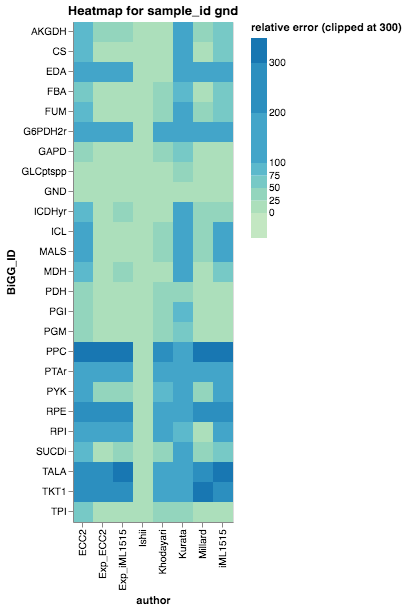

In [15]:
heatmap(x_rel_error, sample_id = "gnd")

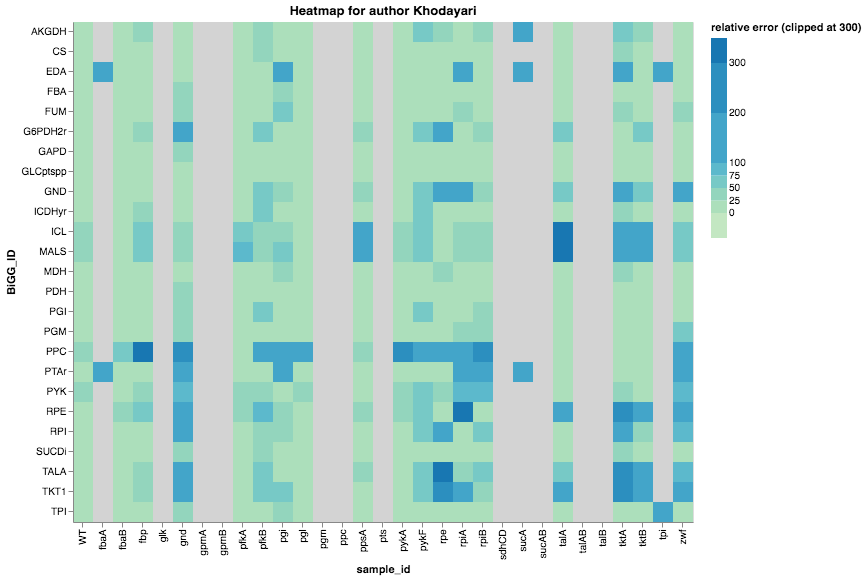

In [13]:
heatmap(x_rel_error, author="Khodayari")

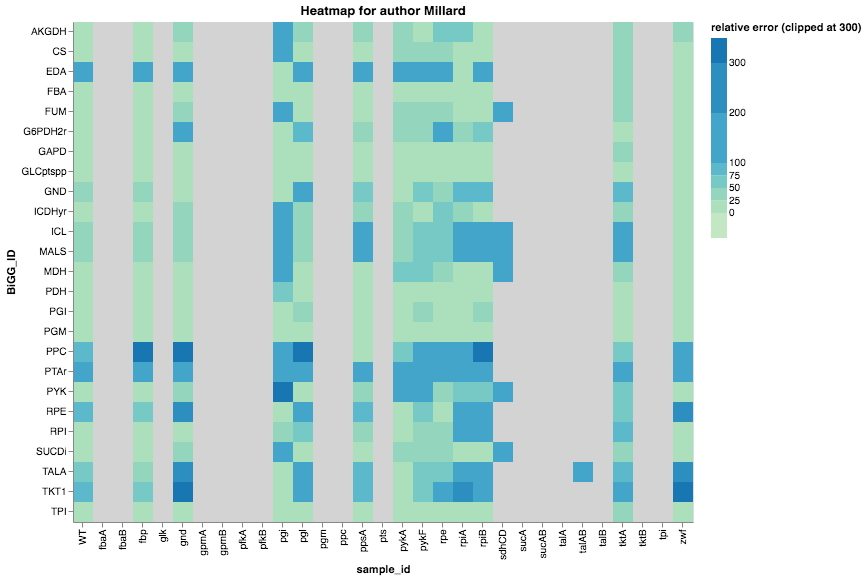

In [14]:
heatmap(x_rel_error, author = "Millard")

### Branch-level error

In [17]:
ishii_branches = branch_stat.sel(author="Ishii")

In [46]:
log_error_diff = xr.ufuncs.log(branch_stat) - xr.ufuncs.log(ishii_branches)
log_error_diff = log_error_diff.rename("error")
#log_error_diff.to_dataframe().reset_index()

In [56]:
rmse_diff = xr.ufuncs.sqrt(xr.ufuncs.square(branch_stat - ishii_branches))
rmse_diff = rmse_diff.rename("error")
rmse_diff = rmse_diff.where(rmse_diff < 10)
#rmse_diff.to_dataframe().reset_index()

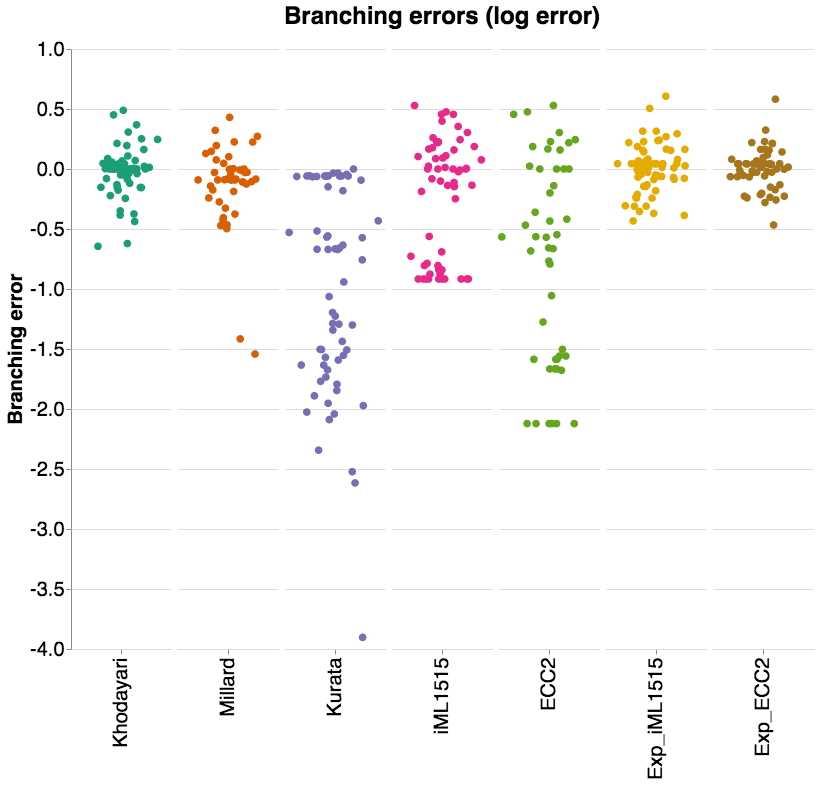

In [59]:
source = log_error_diff.to_dataframe().reset_index()

author = "Ishii"
source = source.query(f"author != '{author}'")

selector = alt.selection_single(empty="none", fields=["sample_id"])
opacity = alt.OpacityValue(1.0)

size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(60))

domain = ["Khodayari", "Millard", "Kurata", "iML1515", "ECC2", "Exp_iML1515", "Exp_ECC2", "Ishii"]
range_ = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666"]
    
stripplot = (
    alt.Chart(source, width=100, height=600)
    .mark_circle()
    .encode(
        x=alt.X(
            "jitter:Q",
            title=None,
            axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),
        ),
        y=alt.Y("error:Q", title="Branching error"),
        color=alt.Color("author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)),
        column=alt.Column(
            "author:N",
            header=alt.Header(
                labelAngle=-90,
                titleOrient="top",
                labelOrient="bottom",
                labelAlign="right",
                labelPadding=3,
                labelFontSize=20,
                title="Branching errors (log error)",
            ),
            sort=domain,
        ),
        size=size,
        opacity=opacity,
        tooltip=["author", "sample_id", "error", "Branch"],
    )
    .transform_calculate(
        # Generate Gaussian jitter with a Box-Muller transform
        jitter="sqrt(-2*log(random()))*cos(2*PI*random())"
    )
    .configure_facet(spacing=5)
    .configure_view(stroke=None)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

stripplot.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(titleFontSize=24)

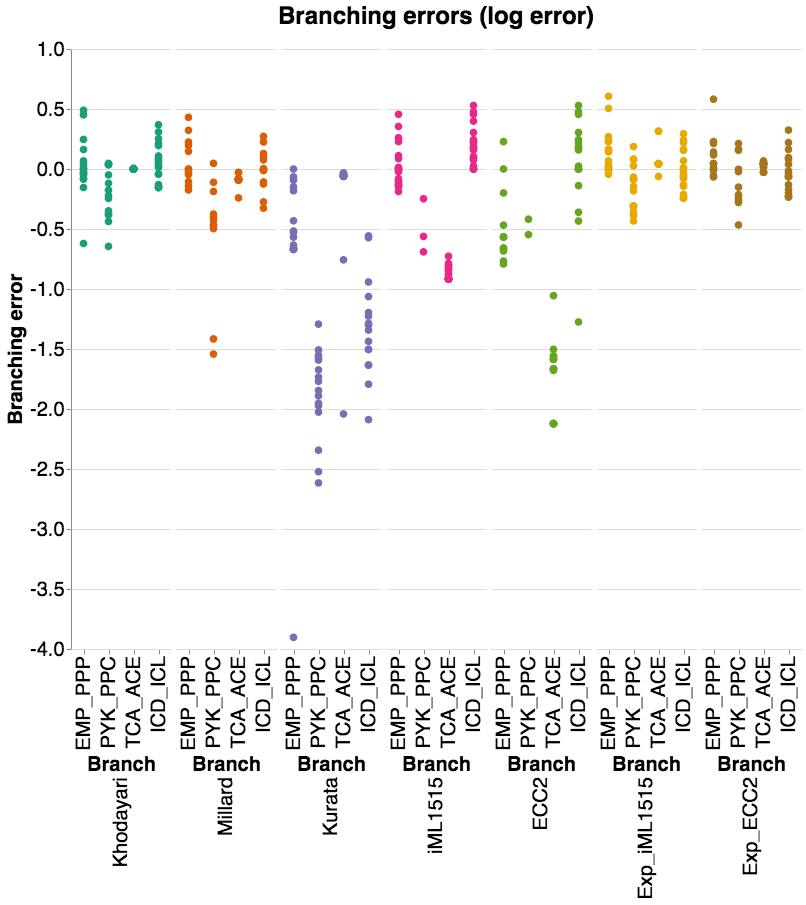

In [60]:
source = log_error_diff.to_dataframe().reset_index()

author = "Ishii"
source = source.query(f"author != '{author}'")

selector = alt.selection_single(empty="none", fields=["sample_id"])
opacity = alt.OpacityValue(1.0)

size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(60))

domain = ["Khodayari", "Millard", "Kurata", "iML1515", "ECC2", "Exp_iML1515", "Exp_ECC2", "Ishii"]
range_ = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666"]
    
stripplot = (
    alt.Chart(source, width=100, height=600)
    .mark_circle()
    .encode(
        x=alt.X(
            "Branch:N",
            #title=None,
            #axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),
            sort = ["EMP_PPP", "PYK_PPC", "TCA_ACE", "ICD_ICL", "MDH_ME"]
        ),
        y=alt.Y("error:Q", title="Branching error"),
        color=alt.Color("author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)),
        column=alt.Column(
            "author:N",
            header=alt.Header(
                labelAngle=-90,
                titleOrient="top",
                labelOrient="bottom",
                labelAlign="right",
                labelPadding=3,
                labelFontSize=20,
                title="Branching errors (log error)",
            ),
            sort=domain,
        ),
        size=size,
        opacity=opacity,
        tooltip=["author", "sample_id", "error", "Branch"],
    )
    .configure_facet(spacing=5)
    .configure_view(stroke=None)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

stripplot.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(titleFontSize=24)

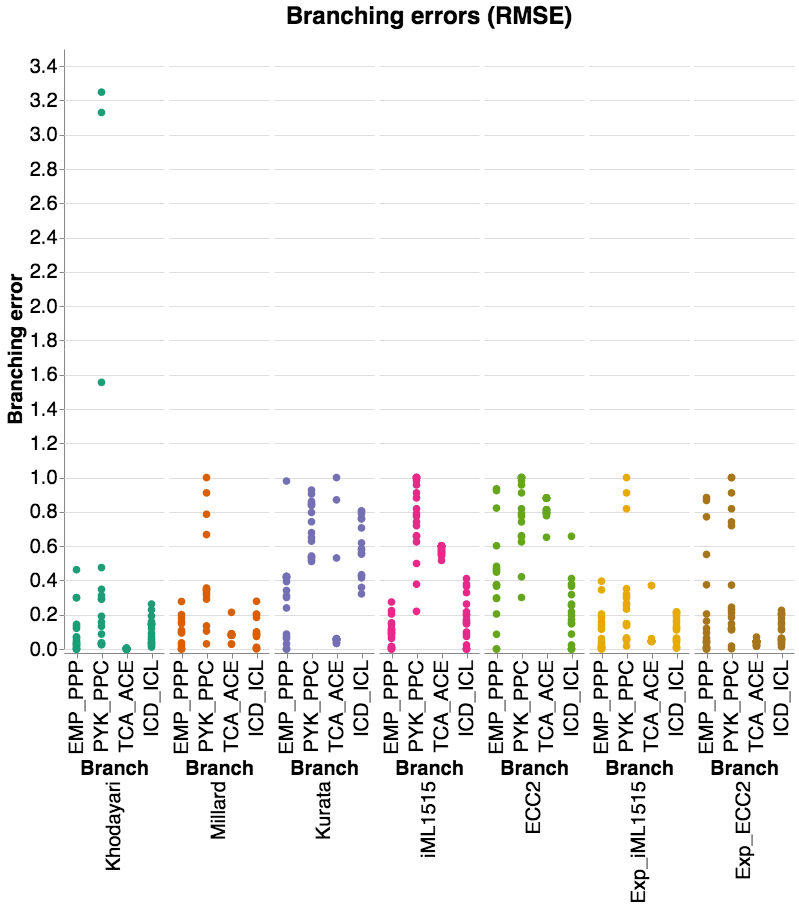

In [61]:
source = rmse_diff.to_dataframe().reset_index()

author = "Ishii"
source = source.query(f"author != '{author}'")

selector = alt.selection_single(empty="none", fields=["sample_id"])
opacity = alt.OpacityValue(1.0)

size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(60))

domain = ["Khodayari", "Millard", "Kurata", "iML1515", "ECC2", "Exp_iML1515", "Exp_ECC2", "Ishii"]
range_ = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666"]
    
stripplot = (
    alt.Chart(source, width=100, height=600)
    .mark_circle()
    .encode(
        x=alt.X(
            "Branch:N",
            #title=None,
            #axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),
            sort = ["EMP_PPP", "PYK_PPC", "TCA_ACE", "ICD_ICL", "MDH_ME"]
        ),
        y=alt.Y("error:Q", title="Branching error"),
        color=alt.Color("author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)),
        column=alt.Column(
            "author:N",
            header=alt.Header(
                labelAngle=-90,
                titleOrient="top",
                labelOrient="bottom",
                labelAlign="right",
                labelPadding=3,
                labelFontSize=20,
                title="Branching errors (RMSE)",
            ),
            sort=domain,
        ),
        size=size,
        opacity=opacity,
        tooltip=["author", "sample_id", "error", "Branch"],
    )
    .configure_facet(spacing=5)
    .configure_view(stroke=None)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

stripplot.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(titleFontSize=24)

# Export the data

In [22]:
data_path = Path('../data')
path =  data_path / "processed"
path.mkdir(parents=True, exist_ok=True)

In [23]:
x_rel_error.to_dataframe().reset_index().to_csv(data_path / "processed" / "ko_relative_errors.csv")

In [24]:
x_norm_error.to_dataframe().reset_index().to_csv(data_path / "processed" / "ko_summary_errors.csv")